# Demo: Nested Lattice Quantization

This notebook demonstrates sampling from a lattice, adding noise, quantizing, and reconstructing vectors using the Nested Lattice Quantizer.

In [2]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.quantizers.lattice.nlq import NLQ as NQ
from src.quantizers.lattice.utils import get_d4, closest_point_Dn, SIG_D4

## Setup D4 Lattice Quantizer

Initialize the D4 lattice quantizer with appropriate parameters.

In [4]:
# D4 lattice parameters
d = 4  # Dimension
G = get_d4()  # Generator matrix for D4 lattice
Q_nn = lambda x: closest_point_Dn(x)  # D4 lattice closest point algorithm
q = 4  # Quantization factor
beta = SIG_D4  # Optimal scaling factor for D4 lattice
alpha = 1.0  # Overload down scaling factor 2^alpha per iteration
eps = np.zeros(d)  # Epsilon
dither = np.zeros(d)  # Dither

# Create quantizer
quantizer =NQ(G, Q_nn, q, beta, alpha, eps, dither)

## Generate Lattice Samples and Test Quantization

We will:
1. Generate samples from the D4 lattice
2. Add Gaussian noise with different scales
3. Quantize the noisy samples
4. Reconstruct the vectors
5. Compute reconstruction error

In [14]:
# Function to generate lattice points
def generate_lattice_point():
    # Generate random integer coordinates
    coords = np.random.randint(-1, 1, size=d)
    # Transform to lattice point using generator matrix
    return np.dot(G, coords)

# Generate samples and test with different noise scales
scales = [0.1, 0.5, 1.0]
n_samples = 5
results = []

for scale in scales:
    for i in range(n_samples):
        # Generate original lattice point
        original = generate_lattice_point()
        
        # Add Gaussian noise
        noisy = scale*(original + np.random.normal(0, 1, size=d))
        
        # Quantize and reconstruct
        enc, T = quantizer.encode(noisy, with_dither=False)
        reconstructed = quantizer.decode(enc, T, with_dither=False)
        
        # Compute error
        error = np.linalg.norm(original - reconstructed)
        
        results.append({
            'Scale': scale,
            'Sample': i + 1,
            'Original': np.round(original, 3),
            'Noisy': np.round(noisy, 3),
            'Overloading': T,
            'Reconstructed': np.round(reconstructed, 3),
            'Error': np.round(error, 3)
        })

## Display Results

In [15]:
# Display results in a formatted table
df = pd.DataFrame(results)
print("\nQuantization Results for Different Scales:")
print("=" * 80)
print(df.to_string(index=False))

# Calculate average error for each noise scale
avg_errors = df.groupby('Scale')['Error'].mean()
print("\nAverage Error by Scale:")
print("=" * 40)
print(avg_errors.to_string())


Quantization Results for Different Scales:
 Scale  Sample      Original                           Noisy  Overloading                 Reconstructed  Error
   0.1       1  [0, 1, 1, 0]    [0.047, 0.287, 0.095, 0.072]            1      [0.0, 0.217, 0.217, 0.0]  1.108
   0.1       2 [0, -1, 1, 0]    [0.127, -0.17, 0.057, 0.018]            0   [0.108, -0.217, 0.108, 0.0]  1.192
   0.1       3  [1, 0, 0, 1]   [0.205, 0.107, -0.045, 0.016]            0   [0.217, 0.108, -0.108, 0.0]  1.279
   0.1       4 [0, 2, -1, 1]  [-0.021, 0.135, -0.145, 0.121]            0   [0.0, 0.108, -0.217, 0.108]  2.233
   0.1       5 [1, 1, -1, 1]    [0.029, 0.14, -0.122, 0.079]            0   [0.0, 0.217, -0.108, 0.108]  1.790
   0.5       1 [0, 0, -1, 1]  [-0.162, 0.382, -0.381, 1.169]            3      [0.0, 0.867, 0.0, 0.867]  1.330
   0.5       2 [0, -1, 0, 1] [0.288, -0.131, -0.422, -0.267]            1  [0.217, 0.0, -0.433, -0.217]  1.648
   0.5       3 [0, 2, -1, 1]   [0.358, 1.426, -0.672, 0.386]        

## Visualize Results

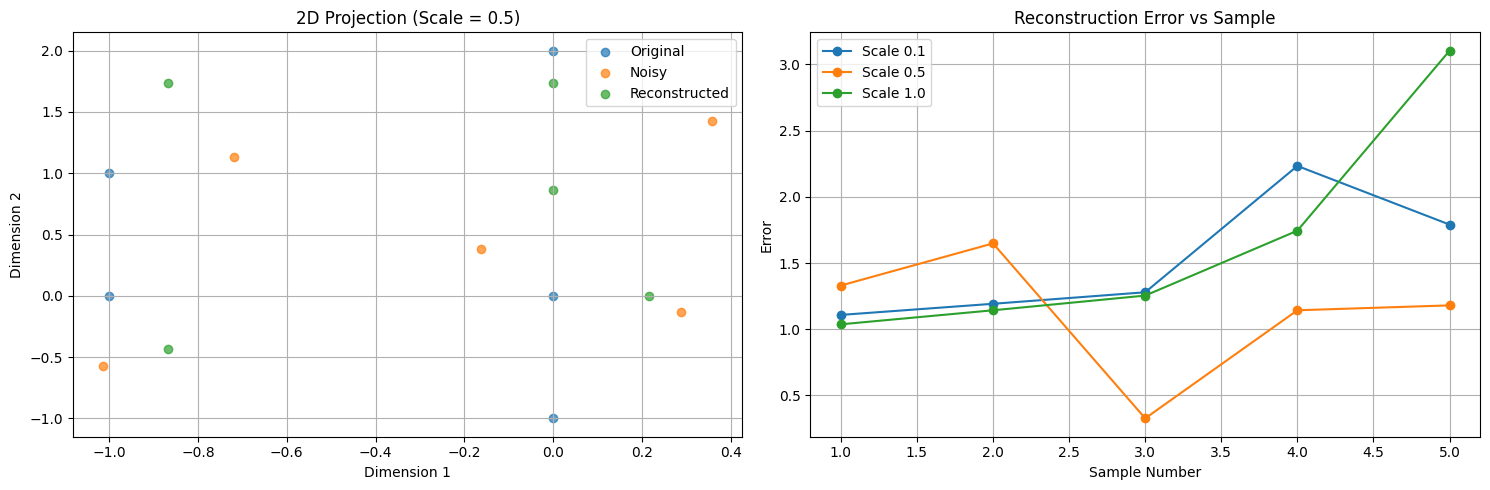

In [16]:
# Visualize original vs reconstructed points for one noise scale
scale_to_plot = 0.5  # middle noise scale
scale_data = df[df['Scale'] == scale_to_plot]

fig = plt.figure(figsize=(15, 5))

# Plot first two dimensions
plt.subplot(121)
plt.scatter([x[0] for x in scale_data['Original']], 
           [x[1] for x in scale_data['Original']], 
           label='Original', alpha=0.7)
plt.scatter([x[0] for x in scale_data['Noisy']], 
           [x[1] for x in scale_data['Noisy']], 
           label='Noisy', alpha=0.7)
plt.scatter([x[0] for x in scale_data['Reconstructed']], 
           [x[1] for x in scale_data['Reconstructed']], 
           label='Reconstructed', alpha=0.7)
plt.title(f'2D Projection (Scale = {scale_to_plot})')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)

# Plot error vs sample number for all scales
plt.subplot(122)
for scale in noise_scales:
    scale_data = df[df['Scale'] == scale]
    plt.plot(scale_data['Sample'], scale_data['Error'], 
             'o-', label=f'Scale {scale}')
plt.title('Reconstruction Error vs Sample')
plt.xlabel('Sample Number')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Test different q values
q_values = [2, 4, 6]
scale = 1  # Fix scale for this analysis
n_samples = 10
q_results = []

# Generate fixed set of test samples
test_samples = [generate_lattice_point() + np.random.normal(0, scale, size=d) for _ in range(n_samples)]

for q_val in q_values:
    # Create quantizer with new q value
    test_quantizer = NestedLatticeQuantizer(
        G=G, 
        Q_nn=Q_nn, 
        q=q_val,
        beta=beta,
        alpha=alpha,
        eps=eps,
        dither=dither
    )
    
    # Test each sample
    for i, sample in enumerate(test_samples):
        enc, T = test_quantizer.encode(sample, with_dither=False)
        reconstructed = test_quantizer.decode(enc, T, with_dither=False)
        error = np.linalg.norm(sample - reconstructed)
        
        q_results.append({
            'q': q_val,
            'Sample': i + 1,
            'Original': np.round(sample, 3),
            'Reconstructed': np.round(reconstructed, 3),
            'Error': np.round(error, 3)
        })

# Create DataFrame for analysis
q_df = pd.DataFrame(q_results)

# Display results
print("\nQuantization Results for Different q values:")
print("=" * 80)
print(q_df.to_string(index=False))

# Calculate average error for each q value
avg_q_errors = q_df.groupby('q')['Error'].mean()
print("\nAverage Error by q value:")
print("=" * 40)
print(avg_q_errors.to_string())

## Analysis of q Parameter Impact

The parameter q affects the quantization in the following ways:
1. Larger q values increase the number of possible quantization levels
2. This can lead to better reconstruction accuracy but requires more bits for encoding
3. However, very large q values might not improve reconstruction significantly due to:
   - The inherent noise in the input signal
   - The scaling factor (beta) becoming the limiting factor
   - The lattice structure's fundamental packing properties

In [ ]:
# Visualize the effect of q on reconstruction error
plt.figure(figsize=(15, 5))


# Plot average error by q
plt.subplot(122)
plt.plot(avg_q_errors.index, avg_q_errors.values, 'o-', linewidth=2)
plt.title('Average Reconstruction Error vs q')
plt.xlabel('q value')
plt.ylabel('Average Error')
plt.grid(True)

plt.tight_layout()
plt.show()

## Analysis of q Parameter Impact on Individual Samples

The detailed analysis above shows:
1. How the encoding vector changes with different q values
2. The reconstruction quality for each q value
3. The trade-off between quantization levels and error
4. The overload factor T for different quantization parameters

Key observations:
- Higher q values typically lead to more precise encodings
- The encoding vector length (number of bits) increases with q
- The reconstruction error generally decreases with higher q
- The overload factor T may vary depending on the input vector and q value

In [ ]:
# Analyze individual samples with different q values
q_values = [2, 4, 8, 16]
scale = 1.0  # Fixed noise scale
n_samples = 5

# Generate fixed samples for consistent comparison
np.random.seed(42)  # For reproducibility
samples = [generate_lattice_point() + np.random.normal(0, scale, size=d) for _ in range(n_samples)]

# Analyze each sample
for idx, sample in enumerate(samples):
    print(f"\nSample {idx + 1}")
    print("=" * 50)
    print(f"Original vector: {np.round(sample, 3)}")
    print("\nQuantization results for different q values:")
    print("-" * 50)
    
    for q_val in q_values:
        # Create quantizer with current q value
        test_quantizer = NestedLatticeQuantizer(
            G=G, 
            Q_nn=Q_nn, 
            q=q_val,
            beta=beta,
            alpha=alpha,
            eps=eps,
            dither=dither
        )
        
        # Quantize and reconstruct
        enc, T = test_quantizer.encode(sample, with_dither=False)
        reconstructed = test_quantizer.decode(enc, T, with_dither=False)
        error = np.linalg.norm(sample - reconstructed)
        
        print(f"\nq = {q_val}:")
        print(f"  Encoding:      {enc}")
        print(f"  Reconstructed: {np.round(reconstructed, 3)}")
        print(f"  Error:         {np.round(error, 3)}")
        print(f"  Overload T:    {T}")

### Understanding the Encoding Process

The encoding process consists of two main components: the inner encoding function and an outer overload handling loop. Here's how it works:

#### Inner Encoding (_encode):
1. **Input Scaling**:
   - Scale input vector x by beta: `x_tag = x/beta`
   - If dithering is enabled, add dither: `x_tag = x_tag + dither`

2. **Lattice Mapping**:
   - Find nearest lattice point: `t = Q_nn(x_tag)`
   - This maps the scaled input to the nearest valid lattice point

3. **Encoding Vector Generation**:
   - Use inverse generator matrix: `y = G_inv * t`
   - Round to integers: `round(y)`
   - Apply modulo q: `enc = y mod q`

4. **Overload Detection**:
   - Scale lattice point: `t_scaled = t/q`
   - Check if scaled point is close to origin: `Q_nn(t_scaled) ≈ 0`
   - If not close to origin, signal overload error

#### Overload Handling (encode):
1. **Initial Attempt**:
   - Try encoding input vector directly
   - Check for overload condition

2. **Iterative Scaling**:
   - If overload occurs:
     * Increment overload counter T
     * Scale input: `x = x/(2^alpha)`
     * Retry encoding
   - Continue until no overload occurs

3. **Final Output**:
   - Return encoding vector (integers in [0, q-1])
   - Return overload factor T

The process ensures that:
- Input vectors are properly mapped to lattice points
- Large values are handled through iterative scaling
- Output encodings are always valid integers in [0, q-1]
- Overload factor T captures the number of scaling iterations needed

This two-stage process allows the quantizer to handle inputs of any magnitude while maintaining the lattice structure's properties.

In [ ]:
def manual_encode_inner(x, G, G_inv, beta, q, Q_nn, dither, with_dither=False):
    print("\nInner Encoding Steps (_encode):")
    
    # Step 1: Scale input by beta
    x_tag = x / beta
    print("1. x_tag = x/beta (scaling input):")
    print(x_tag)
    
    # Step 2: Add dither if used
    if with_dither:
        x_tag = x_tag + dither
        print("2. After adding dither:")
        print(x_tag)
    else:
        print("2. Skipping dither (with_dither=False)")
    
    # Step 3: Find nearest lattice point
    t = Q_nn(x_tag)
    print("3. t = Q_nn(x_tag) (nearest lattice point):")
    print(t)
    
    # Step 4: Convert to encoding space using inverse generator matrix
    y = np.dot(G_inv, t)
    print("4. y = G_inv * t (mapping to encoding space):")
    print(y)
    
    # Step 5: Round and apply modulo q
    enc = np.mod(np.round(y), q).astype(int)
    print("5. Final encoding (round(y) mod q):")
    print(enc)
    
    # Step 6: Check for overload
    scaled_t = t / q
    nearest_to_scaled = Q_nn(scaled_t)
    overload_error = not np.allclose(nearest_to_scaled, 0, atol=1e-8)
    print("6. Overload check:")
    print(f"Scaled t: {scaled_t}")
    print(f"Nearest point to scaled t: {nearest_to_scaled}")
    print(f"Overload occurred: {overload_error}")
    
    return enc, overload_error

def manual_encode(x, q, G, beta, alpha, dither, with_dither=False):
    # Get inverse of generator matrix
    G_inv = np.linalg.inv(G)
    
    print("=== Starting Encoding Process ===")
    print("Input vector x:")
    print(x)
    
    # Initialize
    current_x = x.copy()
    t = 0
    
    # First attempt at encoding
    enc, did_overload = manual_encode_inner(current_x, G, G_inv, beta, q, Q_nn, dither, with_dither)
    
    print("\n=== Overload Handling ===")
    print(f"Initial encoding attempt - Overload occurred: {did_overload}")
    
    # Handle overload by repeatedly scaling down input
    while did_overload:
        t += 1
        current_x = current_x / (2 ** alpha)
        print(f"\nOverload iteration {t}:")
        print(f"Scaled input x/(2^{alpha})^{t}:")
        print(current_x)
        
        enc, did_overload = manual_encode_inner(current_x, G, G_inv, beta, q, Q_nn, dither, with_dither)
        print(f"Overload check after iteration {t}: {did_overload}")
    
    print("\n=== Final Results ===")
    print(f"Final T value: {t}")
    print(f"Final encoding: {enc}")
    
    return enc, t

# Let's test with one of our samples
sample_idx = 0
test_vector = samples[sample_idx]

print("=== Testing Manual Encoding ===")
print("Original vector:", test_vector)

# Get encoding using the quantizer
lib_enc, lib_T = test_quantizer.encode(test_vector, with_dither=False)
print("\nLibrary encoding:")
print("Encoding:", lib_enc)
print("T:", lib_T)

# Get encoding using our manual process
manual_enc, manual_T = manual_encode(
    test_vector, q_val, G, beta, alpha, dither, with_dither=False
)
print("\nManual encoding:")
print("Encoding:", manual_enc)
print("T:", manual_T)

# Compare
print("\nComparison:")
print("Encoding difference:", np.linalg.norm(lib_enc - manual_enc))
print("T difference:", lib_T - manual_T)

### Understanding the Decoding Process

In the output above, the "Encoding" vector (y) for each quantization contains integers in [0, q-1]. These numbers represent:

1. **Coordinates in the Lattice Space**: 
   - Each entry is an integer coordinate in the scaled lattice space
   - The vector length matches the lattice dimension (4 for D4)
   - Values are constrained between 0 and q-1

2. **Decoding Process**:
   The decoding process involves several steps:
   ```
   1. x_p = G * y           # Map encoding to lattice space
   2. x_pp = q * Q_nn(x_p/q) # Find nearest point in scaled lattice
   3. diff = x_p - x_pp     # Compute difference from nearest point
   4. result = beta * diff  # Apply beta scaling
   5. final = result * 2^(alpha * T) # Apply overload scaling
   ```
   
   Key components:
   - G: Generator matrix that maps encoding to lattice space
   - Q_nn: Nearest neighbor function in the lattice
   - q: Quantization parameter that determines the lattice scaling
   - beta: Optimal scaling factor for the lattice
   - T: Overload factor for handling larger values
   - alpha: Overload scaling parameter

3. **Why q matters**:
   - Controls the spacing between lattice points
   - Affects the granularity of quantization
   - Larger q means finer quantization but requires more bits
   - Helps balance between precision and compression

The encoding and decoding process ensures efficient quantization while preserving the lattice structure's geometric properties.

In [ ]:
def manual_decode(enc, q, G, beta, T, Q_nn, alpha, dither, with_dither=False):
    # Convert encoding to numpy array if it's not already
    enc = np.array(enc)
    
    print("\nDebugging Manual Decoding Steps:")
    print("1. Input encoding vector y:", enc)
    
    # Step 1: Map encoding to lattice space using generator matrix
    x_p = np.dot(G, enc)
    print("\n2. x_p = G * y (mapping to lattice space):")
    print(x_p)
    
    # Step 2: Remove dither if used
    if with_dither:
        x_p = x_p - dither
        print("\n3. After removing dither:")
        print(x_p)
    else:
        print("\n3. Skipping dither removal (with_dither=False)")
    
    # Step 3: Find nearest point in scaled lattice
    # First scale down by q, find nearest lattice point, then scale back up
    x_p_scaled = x_p / q
    print("\n4. x_p/q (scaling down for nearest point search):")
    print(x_p_scaled)
    
    nearest_point = Q_nn(x_p_scaled)
    print("\n5. Nearest lattice point:")
    print(nearest_point)
    
    x_pp = q * nearest_point
    print("\n6. x_pp = q * nearest_point (scaling back up):")
    print(x_pp)
    
    # Step 4: Compute difference and apply beta scaling
    diff = x_p - x_pp
    print("\n7. x_p - x_pp (difference from nearest point):")
    print(diff)
    
    base_result = beta * diff
    print("\n8. After beta scaling:")
    print(base_result)
    
    # Step 5: Apply overload factor
    final_result = base_result * (2 ** (alpha * T))
    print("\n9. Final result after applying overload factor 2^(alpha*T):")
    print(f"alpha: {alpha}, T: {T}, scaling: {2 ** (alpha * T)}")
    print(final_result)
    
    return final_result

# Let's verify this with one of our previous examples
sample_idx = 0  # Let's use the first sample
q_val = 4      # Choose one q value for demonstration

# Create quantizer
test_quantizer = NestedLatticeQuantizer(
    G=G, 
    Q_nn=Q_nn, 
    q=q_val,
    beta=beta,
    alpha=alpha,
    eps=eps,
    dither=dither
)

# Get the encoding
enc, T = test_quantizer.encode(samples[sample_idx], with_dither=False)

print("\n=== Input and Results ===")
print("Original Sample:", np.round(samples[sample_idx], 3))
print("Encoding vector:", enc)
print("Overload factor T:", T)

# Get reconstruction using quantizer's decode method
quantizer_reconstruction = test_quantizer.decode(enc, T, with_dither=False)
print("\nQuantizer reconstruction:", np.round(quantizer_reconstruction, 3))

# Get reconstruction using our manual formula
manual_reconstruction = manual_decode(
    enc, q_val, G, beta, T, Q_nn, alpha, dither, with_dither=False
)
print("\nManual reconstruction:", np.round(manual_reconstruction, 3))

# Compare the two reconstructions
difference = np.linalg.norm(quantizer_reconstruction - manual_reconstruction)
print("\nDifference magnitude:", np.round(difference, 6))
print("Component-wise difference:", np.round(quantizer_reconstruction - manual_reconstruction, 6))